<a href="https://colab.research.google.com/github/raju07ra/AI-Applications-for-Digital-Business/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
from io import BytesIO
from zipfile import ZipFile

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Configuration
sns.set_style("whitegrid")
nltk.download('stopwords', quiet=True)

print("Libraries loaded successfully.")

Libraries loaded successfully.


Loading local file: IMDB Dataset.csv


/tmp/ipython-input-470632515.py:10: ParserWarning: Skipping line 10275: unexpected end of data

  df = pd.read_csv(file_name, engine='python', on_bad_lines='warn')


Saved graph: 1_class_balance.png


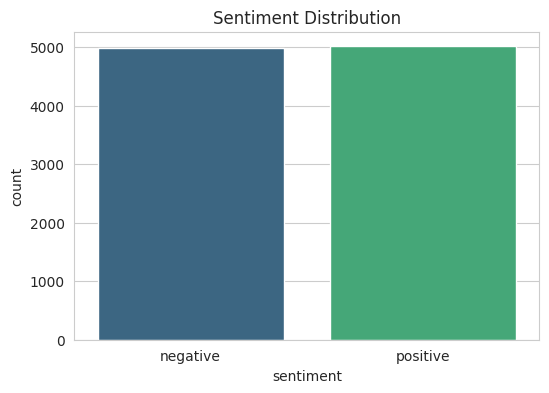

In [24]:
def load_data():
    file_name = 'IMDB Dataset.csv'

    if os.path.exists(file_name):
        print(f"Loading local file: {file_name}")
        try:

            df = pd.read_csv(file_name, engine='python', on_bad_lines='warn')
        except Exception as e:
            print(f"Error reading local CSV: {e}. Please check the file's format.")
            return None
    else:
        print("Local file not found. Automatic download from online sources has been problematic.")
        print("Please ensure 'IMDB Dataset.csv' is uploaded to your Colab environment or manually provide a working URL.")
        return None

    if len(df) >= 10000:
        return df.sample(10000, random_state=42)
    else:
        print(f"Dataset has fewer than 10,000 rows ({len(df)} rows). Using the full dataset.")
        return df

df = load_data()

#Class Balance
if df is not None:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='sentiment', data=df, hue='sentiment', palette='viridis', legend=False)
    plt.title('Sentiment Distribution')
    plt.savefig('1_class_balance.png')
    print("Saved graph: 1_class_balance.png")

In [25]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)

    # Keep only letters and lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text).lower()

    # Remove stopwords and apply stemming
    words = text.split()
    ps = PorterStemmer()
    stops = set(stopwords.words('english'))

    clean_words = [ps.stem(w) for w in words if w not in stops]
    return ' '.join(clean_words)

print("Cleaning text...")
df['cleaned_review'] = df['review'].apply(clean_text)
print("Done.")

Cleaning text...
Done.


In [27]:
# 80/20 Split
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'],
    df['sentiment'],
    test_size=0.2,
    random_state=42
)

# Vectorization (TF-IDF)
print("Vectorizing...")
tfidf = TfidfVectorizer(max_features=5000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

# Model Training
print("Training model...")
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)

Vectorizing...
Training model...


LogisticRegression(max_iter=1000)

Accuracy: 87.10%
Saved graph: 2_confusion_matrix.png
Saved graph: 3_feature_importance.png


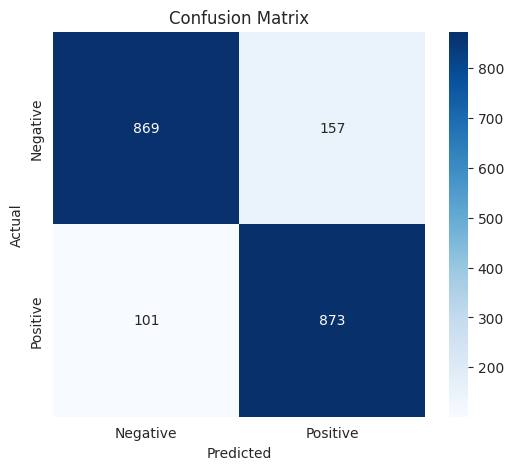

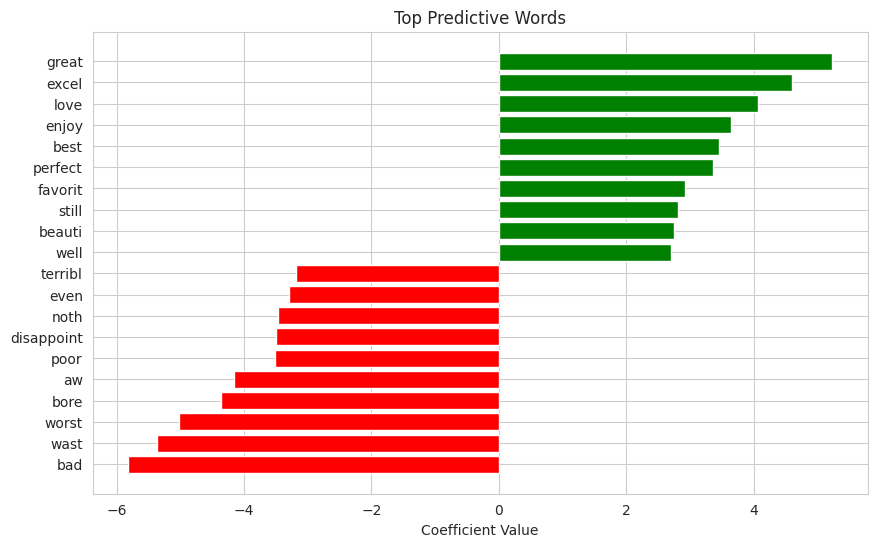

In [28]:
# Predictions
y_pred = model.predict(X_test_vec)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc*100:.2f}%")

# Graph 2: Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('2_confusion_matrix.png')
print("Saved graph: 2_confusion_matrix.png")

# Graph 3: Feature Importance
feature_names = tfidf.get_feature_names_out()
coefs = model.coef_[0]

# top 10 positive and negative words
top_pos = np.argsort(coefs)[-10:]
top_neg = np.argsort(coefs)[:10]
top_indices = np.hstack([top_neg, top_pos])

plt.figure(figsize=(10, 6))
colors = ['red' if coefs[i] < 0 else 'green' for i in top_indices]
plt.barh([feature_names[i] for i in top_indices], coefs[top_indices], color=colors)
plt.title('Top Predictive Words')
plt.xlabel('Coefficient Value')
plt.savefig('3_feature_importance.png')
print("Saved graph: 3_feature_importance.png")

In [30]:
print("\n--- Testing Custom Examples ---")

new_reviews = [
    "The battery life is amazing and the screen is beautiful.",
    "I waited two weeks for delivery and it arrived broken. Terrible service.",
    "It is okay, not the best but good for the price."
]

print("Predictions for new customer reviews:")

new_clean = [clean_text(r) for r in new_reviews]

new_vec = tfidf.transform(new_clean)

predictions = model.predict(new_vec)

for review, sentiment in zip(new_reviews, predictions):
    print(f"Review: '{review}'\n -> AI Prediction: {sentiment.upper()}\n")


--- Testing Custom Examples ---
Predictions for new customer reviews:
Review: 'The battery life is amazing and the screen is beautiful.'
 -> AI Prediction: POSITIVE

Review: 'I waited two weeks for delivery and it arrived broken. Terrible service.'
 -> AI Prediction: NEGATIVE

Review: 'It is okay, not the best but good for the price.'
 -> AI Prediction: POSITIVE

